In [1]:
import tejapi
import copy
import pandas as pd
from scipy import stats
from collections import OrderedDict
import matplotlib.pyplot as plt

tejapi.ApiConfig.api_key = 'Your Key'

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 避免 plot作圖出現中文亂碼問題
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 匯入資料
# 撈取上市所有普通股證券代碼
code = tejapi.get("TWN/EWNPRCSTD", paginate=True, chinese_column_name=True)
code = code["證券碼"][(code["證券種類名稱"] == "普通股") & (code["上市別"].isin(["TSE"]))].to_list()

In [3]:
# 匯入 ROE變數 
data_ROE = tejapi.get('TWN/AIFIN',
                      coid = code,
                      mdate= {'gte': '2018-01-01','lte':'2020-12-31'},
                      opts={'pivot':True ,'columns':['coid', 'mdate', 'R103']},
                      chinese_column_name=True,
                      paginate=True)

In [4]:
# 匯入 財報發布日 
data_annouce = tejapi.get('TWN/AIFINA',
                          coid = code,
                          mdate= {'gte': '2018-01-01','lte':'2020-12-31'},
                          opts={'columns':['coid', 'mdate', 'a0003']},
                          chinese_column_name=True,
                          paginate=True)

In [5]:
# 匯入 調整後開盤價、收盤價與股價淨值比
data_PB_price = tejapi.get('TWN/APRCD1',
                           coid = code,
                           mdate= {'gte': '2019-01-01','lte':'2020-12-31'},
                           opts={'columns':['coid', 'mdate','open_adj','close_adj','pbr_tej']},
                           chinese_column_name=True,
                           paginate=True)

data_PB_price.head()

,證券代碼,年月日,開盤價(元),收盤價(元),股價淨值比-TEJ
None,,,,,
0,1101,2019-01-02 00:00:00+00:00,26.0018,25.8200,1.07
1,1101,2019-01-03 00:00:00+00:00,25.8200,25.5654,1.06
2,1101,2019-01-04 00:00:00+00:00,25.4563,25.7836,1.06
3,1101,2019-01-07 00:00:00+00:00,26.0746,26.1837,1.08
4,1101,2019-01-08 00:00:00+00:00,26.1109,25.8564,1.07


In [6]:
# 資料前處理

# 整理股價
data_PB_price = data_PB_price.rename({'證券代碼': '公司'}, axis=1) # 改名字
data_PB_price['開盤價(元) t+1'] = data_PB_price.groupby('公司')['開盤價(元)'].shift(-1) 

# 新增年與月
data_PB_price['年'] = data_PB_price['年月日'].dt.year
data_PB_price['月'] = data_PB_price['年月日'].dt.month
data_PB_price = data_PB_price.sort_values(by=['年月日']).reset_index(drop=True) # 排序年月日

In [7]:
# 合併資料

# 併季頻率的 ROE與財報發布日
data_all = pd.merge(data_ROE ,data_annouce ,how = 'left' , on = ['公司','年/月'])
data_all = data_all.rename({'年/月': '財報'}, axis=1) # 改名字
data_all = data_all.sort_values(by=['財報發布日']).reset_index(drop=True) # 排序財報發布日

# 併季頻率與日頻率資料
data_all = pd.merge_asof(data_PB_price ,data_all ,left_on = '年月日', right_on = '財報發布日',
                         by = ['公司'] ,direction = "backward")

# 留下每月底資料
data_all = data_all.drop_duplicates(subset=['公司','年','月'], keep='last')
data_all = data_all.sort_values(by=['公司','年月日']).reset_index(drop=True)

data_all['月持有報酬率'] = data_all.groupby('公司')['收盤價(元)'].shift(-1).reset_index(drop=True) \
    / data_all['開盤價(元) t+1'] -1

data_all.tail(6)

,公司,年月日,開盤價(元),收盤價(元),股價淨值比-TEJ,開盤價(元) t+1,年,月,財報,ROE(A)－稅後,財報發布日,月持有報酬率
22331,9958,2020-07-31 00:00:00+00:00,89.9485,88.8880,4.2462,90.0449,2020,7,2020-03-01 00:00:00+00:00,1.88,2020-05-13 00:00:00+00:00,0.329519
22332,9958,2020-08-31 00:00:00+00:00,111.9300,119.7164,5.6786,119.7164,2020,8,2020-06-01 00:00:00+00:00,5.78,2020-08-12 00:00:00+00:00,0.040650
22333,9958,2020-09-30 00:00:00+00:00,121.6630,124.5829,5.9309,125.0696,2020,9,2020-06-01 00:00:00+00:00,5.78,2020-08-12 00:00:00+00:00,0.011673
22334,9958,2020-10-30 00:00:00+00:00,128.4761,126.5295,6.0408,127.0162,2020,10,2020-06-01 00:00:00+00:00,5.78,2020-08-12 00:00:00+00:00,0.000000
22335,9958,2020-11-30 00:00:00+00:00,127.5028,127.0162,6.2288,127.9895,2020,11,2020-09-01 00:00:00+00:00,11.36,2020-11-12 00:00:00+00:00,-0.186312
22336,9958,2020-12-31 00:00:00+00:00,106.5768,104.1435,4.4197,NaN,2020,12,2020-09-01 00:00:00+00:00,11.36,2020-11-12 00:00:00+00:00,NaN


In [8]:
data_all = data_all.dropna().reset_index(drop=True) # 刪除缺失值
data_all = data_all.set_index(['年月日','公司']) # 設年月日、公司為index
data_all = data_all[['股價淨值比-TEJ','ROE(A)－稅後','月持有報酬率']] # 只留三欄

In [9]:
#%% 新增分組別、IC、IR

# 獲得因子排名
def get_rank(data):
    factors_name=[i for i in data.columns.tolist() if i not in ['月持有報酬率']] # 得到因子名
    
    rank_df = []
    for factor in factors_name:
        if factor in ['股價淨值比-TEJ']:
            rank_list = data[factor].groupby(level=0).rank(ascending = True) # rank由小到大排序，即值越小，排名越靠前
        else:
            rank_list = data[factor].groupby(level=0).rank(ascending = False) # rank由大到小排序，即值越大，排名越靠前
        
        rank_df.append(rank_list)
        
    rank_df = pd.concat(rank_df, axis=1)
    return rank_df


# 等權重法
def equal_weight(datas):
    datas_= copy.deepcopy(datas)
    ranks = get_rank(datas)
    weight = ranks.mean(axis=1).to_frame().rename(columns={0:'score'})
    datas_ = datas_.join(weight)
    datas_ = datas_.reset_index()
    return datas_ 


data_equal = equal_weight(data_all)
data_equal['因子每年分組'] = data_equal.groupby('年月日')['score'].rank(ascending = False).\
    transform(lambda x: pd.qcut(x, 10, labels = range(1,11))) # rank由大到小排序，即值越大，排名越靠前

data_equal.head(10)

,年月日,公司,股價淨值比-TEJ,ROE(A)－稅後,月持有報酬率,score,因子每年分組
0,2019-01-30 00:00:00+00:00,1101,1.1200,10.07,0.013190,337.50,9
1,2019-02-27 00:00:00+00:00,1101,1.1530,10.07,0.074220,335.25,9
2,2019-03-29 00:00:00+00:00,1101,1.2386,12.94,0.010830,346.00,9
3,2019-04-30 00:00:00+00:00,1101,1.2611,12.94,0.016587,341.50,9
4,2019-05-31 00:00:00+00:00,1101,1.2881,2.08,0.079719,410.00,7
5,2019-06-28 00:00:00+00:00,1101,1.2117,2.08,-0.029316,399.00,7
6,2019-07-31 00:00:00+00:00,1101,1.1762,2.08,-0.000139,390.00,8
7,2019-08-30 00:00:00+00:00,1101,1.0825,6.00,0.031210,312.50,10
8,2019-09-27 00:00:00+00:00,1101,1.1163,6.00,0.013784,316.50,10
9,2019-10-31 00:00:00+00:00,1101,1.2015,6.00,0.023487,333.00,9


In [10]:
# 獲得IC數值
def get_ic(data):
    factors_name=[i for i in data.columns.tolist() if i not in ['月持有報酬率']] # 得到因子名
    ic = data.groupby(level=0).\
        apply(lambda data: [stats.spearmanr(data[factor],
                                            data['月持有報酬率'])[1] for factor in factors_name])
        
    ic = pd.DataFrame(ic.tolist(), index=ic.index, columns=factors_name)
    return ic

# 根據IC計算因子權重
def ic_weight(data):
    data_= data.copy()
    ic = get_ic(data)  
    ic0 = ic.abs() # 計算 IC絕對值
    rolling_ic = ic0.rolling(12,min_periods=1).mean()  # 滾動 12个月
    weight = rolling_ic.div(rolling_ic.sum(axis=1),axis=0)  # 計算 IC權重,按行求和,按列相除
    ranks = get_rank(data)   # 得到各因子的排序數據
    
    score_ = OrderedDict()
    for date in weight.index.tolist():
        rank = ranks.loc[date]
        score = rank * weight.loc[date] 
        score_[date] = score.sum(axis=1).to_frame().rename(columns={0: 'score'})
    
    score_df = pd.concat(score_.values(),keys=score_.keys())
    score_df = score_df.reset_index().rename({'level_0': '年月日'}, axis=1)
    score_df = score_df.set_index(['年月日','公司'])
    data_ = data_.join(score_df)
    data_ = data_.reset_index()
    return data_

In [11]:
data_ic = ic_weight(data_all)
data_ic['因子每年分組'] = data_ic.groupby('年月日')['score'].rank(ascending = False).\
    transform(lambda x: pd.qcut(x, 10, labels = range(1,11)))

data_ic.head(10)

,年月日,公司,股價淨值比-TEJ,ROE(A)－稅後,月持有報酬率,score,因子每年分組
0,2019-01-30 00:00:00+00:00,1101,1.1200,10.07,0.013190,385.636540,6
1,2019-02-27 00:00:00+00:00,1101,1.1530,10.07,0.074220,377.952277,7
2,2019-03-29 00:00:00+00:00,1101,1.2386,12.94,0.010830,392.929197,7
3,2019-04-30 00:00:00+00:00,1101,1.2611,12.94,0.016587,335.009460,9
4,2019-05-31 00:00:00+00:00,1101,1.2881,2.08,0.079719,405.947706,7
5,2019-06-28 00:00:00+00:00,1101,1.2117,2.08,-0.029316,406.085920,7
6,2019-07-31 00:00:00+00:00,1101,1.1762,2.08,-0.000139,394.860516,7
7,2019-08-30 00:00:00+00:00,1101,1.0825,6.00,0.031210,323.684003,9
8,2019-09-27 00:00:00+00:00,1101,1.1163,6.00,0.013784,331.420102,9
9,2019-10-31 00:00:00+00:00,1101,1.2015,6.00,0.023487,350.885597,8


In [12]:
#%% 分組並回測

def arrange_group_return(tempt):
    tempt = tempt.groupby(['年月日','因子每年分組'])[['月持有報酬率']].mean().reset_index()
    tempt['月持有報酬率'] = tempt['月持有報酬率'] * 100
    tempt = pd.pivot_table(tempt, values='月持有報酬率', index=['因子每年分組'] ,columns=['年月日'])
    tempt.index = tempt.index.astype(str)
    tempt = tempt.T
    tempt = tempt.cumsum().dropna()
    tempt.index = tempt.index.astype(str).str[:7]
    
    return tempt

data_equal = arrange_group_return(data_equal)
data_ic = arrange_group_return(data_ic)

data_equal.round(2).head(10)

因子每年分組,1,2,3,4,5,6,7,8,9,10
年月日,,,,,,,,,,
2019-01,3.51,4.07,3.98,3.67,3.47,4.45,4.21,3.81,3.50,3.42
2019-02,6.05,7.43,4.76,4.97,6.07,7.75,5.71,5.70,5.33,4.87
2019-03,3.86,7.49,5.23,6.05,5.02,8.71,6.90,6.75,7.42,4.88
2019-04,-4.49,3.47,0.88,4.03,2.90,6.10,4.04,4.56,6.01,2.77
2019-05,-2.67,6.37,3.93,6.60,6.37,9.81,5.91,7.76,7.61,4.56
2019-06,-0.84,9.23,6.47,8.44,9.04,14.12,8.90,10.10,10.57,8.02
2019-07,-1.31,10.10,6.72,9.42,10.29,12.99,9.35,10.58,9.46,6.83
2019-08,1.20,11.41,6.58,9.57,10.16,13.59,9.99,11.61,8.91,7.46
2019-09,1.58,14.90,11.03,11.21,11.60,15.85,11.86,13.32,11.18,8.83


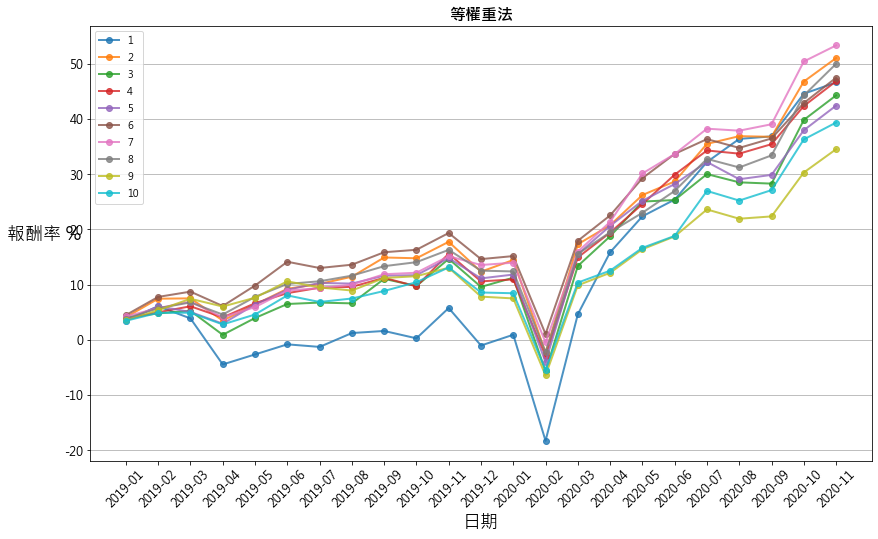

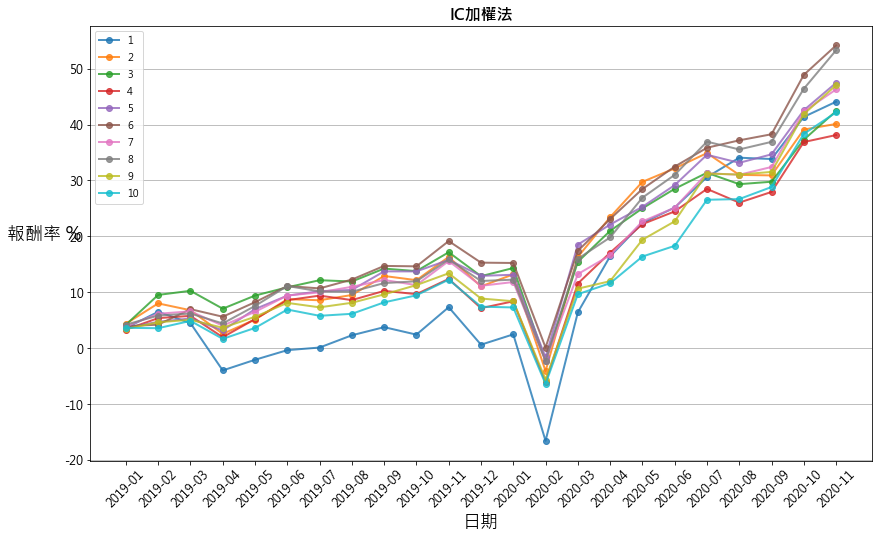

In [13]:
def draw_group_return(tempt ,weight_method):
    fig = plt.figure(figsize = (14,8))
    ax = fig.add_subplot()
    
    ax.set_title(weight_method, 
                 fontsize=16, 
                 fontweight='bold')
    
    for i in tempt.columns:
        ax.plot(tempt[i], linewidth=2, alpha=0.8 , marker='o')
    
    ax.legend(tempt.columns,loc=2)
    
    plt.grid(axis='y')
    plt.xlabel('日期', fontsize=18)
    plt.ylabel('報酬率 %',rotation=0, fontsize=18,labelpad=20)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    plt.show()
    
draw_group_return(data_equal, '等權重法')
draw_group_return(data_ic, 'IC加權法')

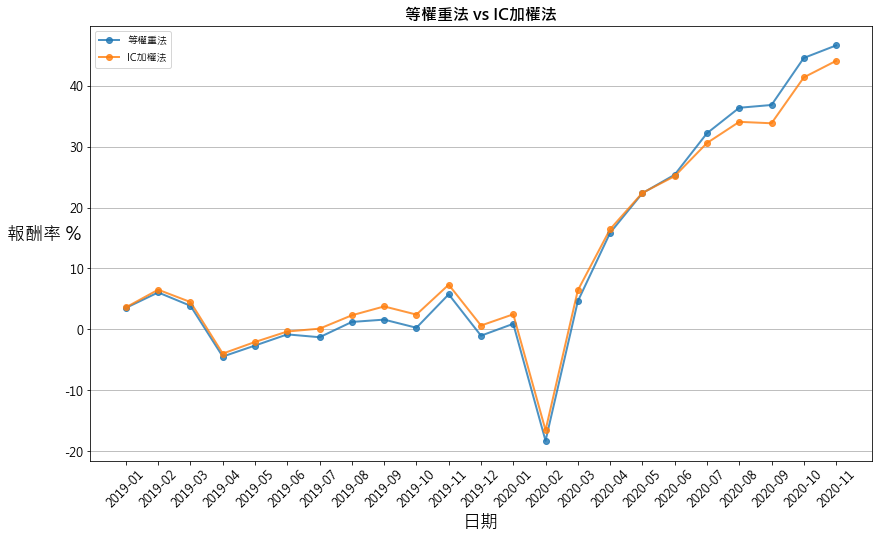

In [14]:
# 比較 等權重法與 IC加權法
data_equal_ir = pd.merge(pd.DataFrame(data_equal['1']).rename({'1':'等權重法'}, axis=1),
                         pd.DataFrame(data_ic['1']).rename({'1':'IC加權法'}, axis=1),
                         how='inner',left_index=True, right_index=True)

draw_group_return(data_equal_ir, '等權重法 vs IC加權法')